In [1]:
# import neccessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# show plot intermediately under the calling cell
%matplotlib inline

# disable some warnings
import warnings
warnings.simplefilter(action = "ignore")

# set to unlimited column display:
pd.set_option('display.max_columns', None)

# import database
df = pd.read_csv('results-2014.csv')

<center>Table: (sample) Dataframe including column dtype</center>

In [2]:
dtypes = pd.Series(df.dtypes,name='dtypes')
df.head(2).append(dtypes)

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,116.37,21,5.3,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
dtypes,object,object,int64,object,object,int64,float64,object,int64,object,object,int64,float64,object,object,object,object,object,object,object,object


In [2]:
df['type']=0
df.loc[df.bib.str.contains('W'), 'type'] = 1
df.loc[df.bib.str.contains('F'), 'type'] = 2

In [3]:
df.type.value_counts()

0    31883
1       53
2       48
Name: type, dtype: int64

# 1. Data cleaning

We convert Gender to number using label encoder with Female is 0 and Male is 1.

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.gender = le.fit_transform(df.gender)

# show label and encoded values
for i, classes in enumerate(le.classes_):
    print("Label:",classes + ", Encoded value:",i )

Label: F, Encoded value: 0
Label: M, Encoded value: 1


We drop rows where distance is not numeric-convertable then  apply the convertion and delete categorical columns.

In [4]:
# drop rows where distance is '-'
df.drop(df[df['10k']=='-'].index, axis=0, inplace=True)
df.drop(df[df['25k']=='-'].index, axis=0, inplace=True)
df.drop(df[df['35k']=='-'].index, axis=0, inplace=True)
df.drop(df[df['30k']=='-'].index, axis=0, inplace=True)
df.drop(df[df['half']=='-'].index, axis=0, inplace=True)
df.drop(df[df['20k']=='-'].index, axis=0, inplace=True)
df.drop(df[df['40k']=='-'].index, axis=0, inplace=True)
df.drop(df[df['5k']=='-'].index, axis=0, inplace=True)

# Convert to numeric
df['10k']=pd.to_numeric(df['10k'])
df['25k']=pd.to_numeric(df['25k'])
df['35k']=pd.to_numeric(df['35k'])
df['30k']=pd.to_numeric(df['30k'])
df['half']=pd.to_numeric(df['half'])
df['20k']=pd.to_numeric(df['20k'])
df['40k']=pd.to_numeric(df['40k'])
df['5k']=pd.to_numeric(df['5k'])

# clean outlier
df.drop(df[df['40k']>400].index, axis=0, inplace=True)

#rearrange column order
df=df[['gender','age','type','division','genderdiv','overall','pace','5k','10k','20k','half','25k','30k','35k','40k','official']]

<center>Table: Processed database

In [12]:
dtypes = pd.Series(df.dtypes,name='dtypes')
df.head(2).append(dtypes)

,gender,age,type,division,genderdiv,overall,pace,5k,10k,20k,half,25k,30k,35k,40k,official
0,1,47,1,8,8,8,3.27,8.02,17.37,37.65,39.72,47.67,59.18,71.4,80.43,85.25
1,0,33,2,1,1,21,5.3,16.22,32.58,65.83,69.47,82.43,99.33,116.37,132.1,138.95
dtypes,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


# 2. Descriptive Statistics

We plot the line of all the milestones with the average speed from candidates.

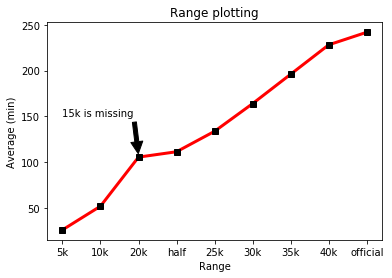

The line can't visualize the speed correctly (the more steep the line is, the faster the average speed of candidates reach) as the milestones are not equally spaced. So we will directly calculate and plot the speed of them.

In [71]:
cspeed = [5,10,20,25,30,35,40]/df.loc[:,['5k','10k','20k','25k','30k','35k','40k']].mean()*1000/60

rdis = df.loc[:,['5k','10k','20k','25k','30k','35k','40k']].mean()
# shift range distance
rs = rdis.shift(1)
rs.loc['5k']=0
rspeed = [5,5,10,5,5,5,5]/(rdis-rs)*1000/60
pd.DataFrame([cspeed,rspeed],index=['cummulative speed','range speed'])

,5k,10k,20k,25k,30k,35k,40k
cummulative speed,3.245287,3.228157,3.164915,3.119202,3.050736,2.975684,2.921542
range speed,3.245287,3.211207,3.104104,2.948832,2.749031,2.592945,2.591483


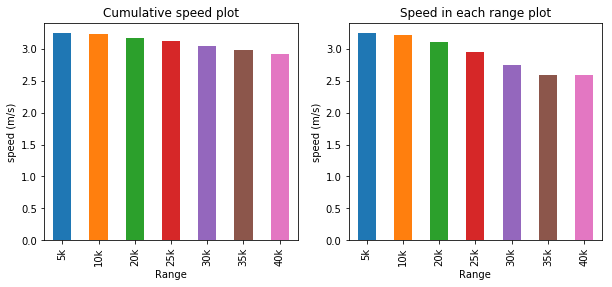

The right plot explains the speed in each range more precisely. It not only shows how the speed decrease but also the stability of speed in the last 10km to the finish line.

<center>Figure: Correlation Matrix of some columns</center>

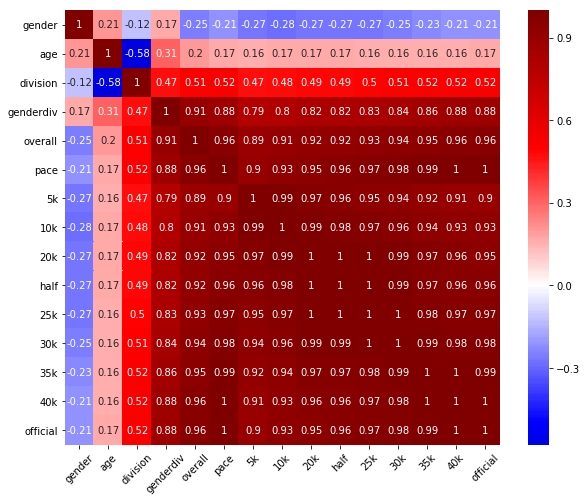

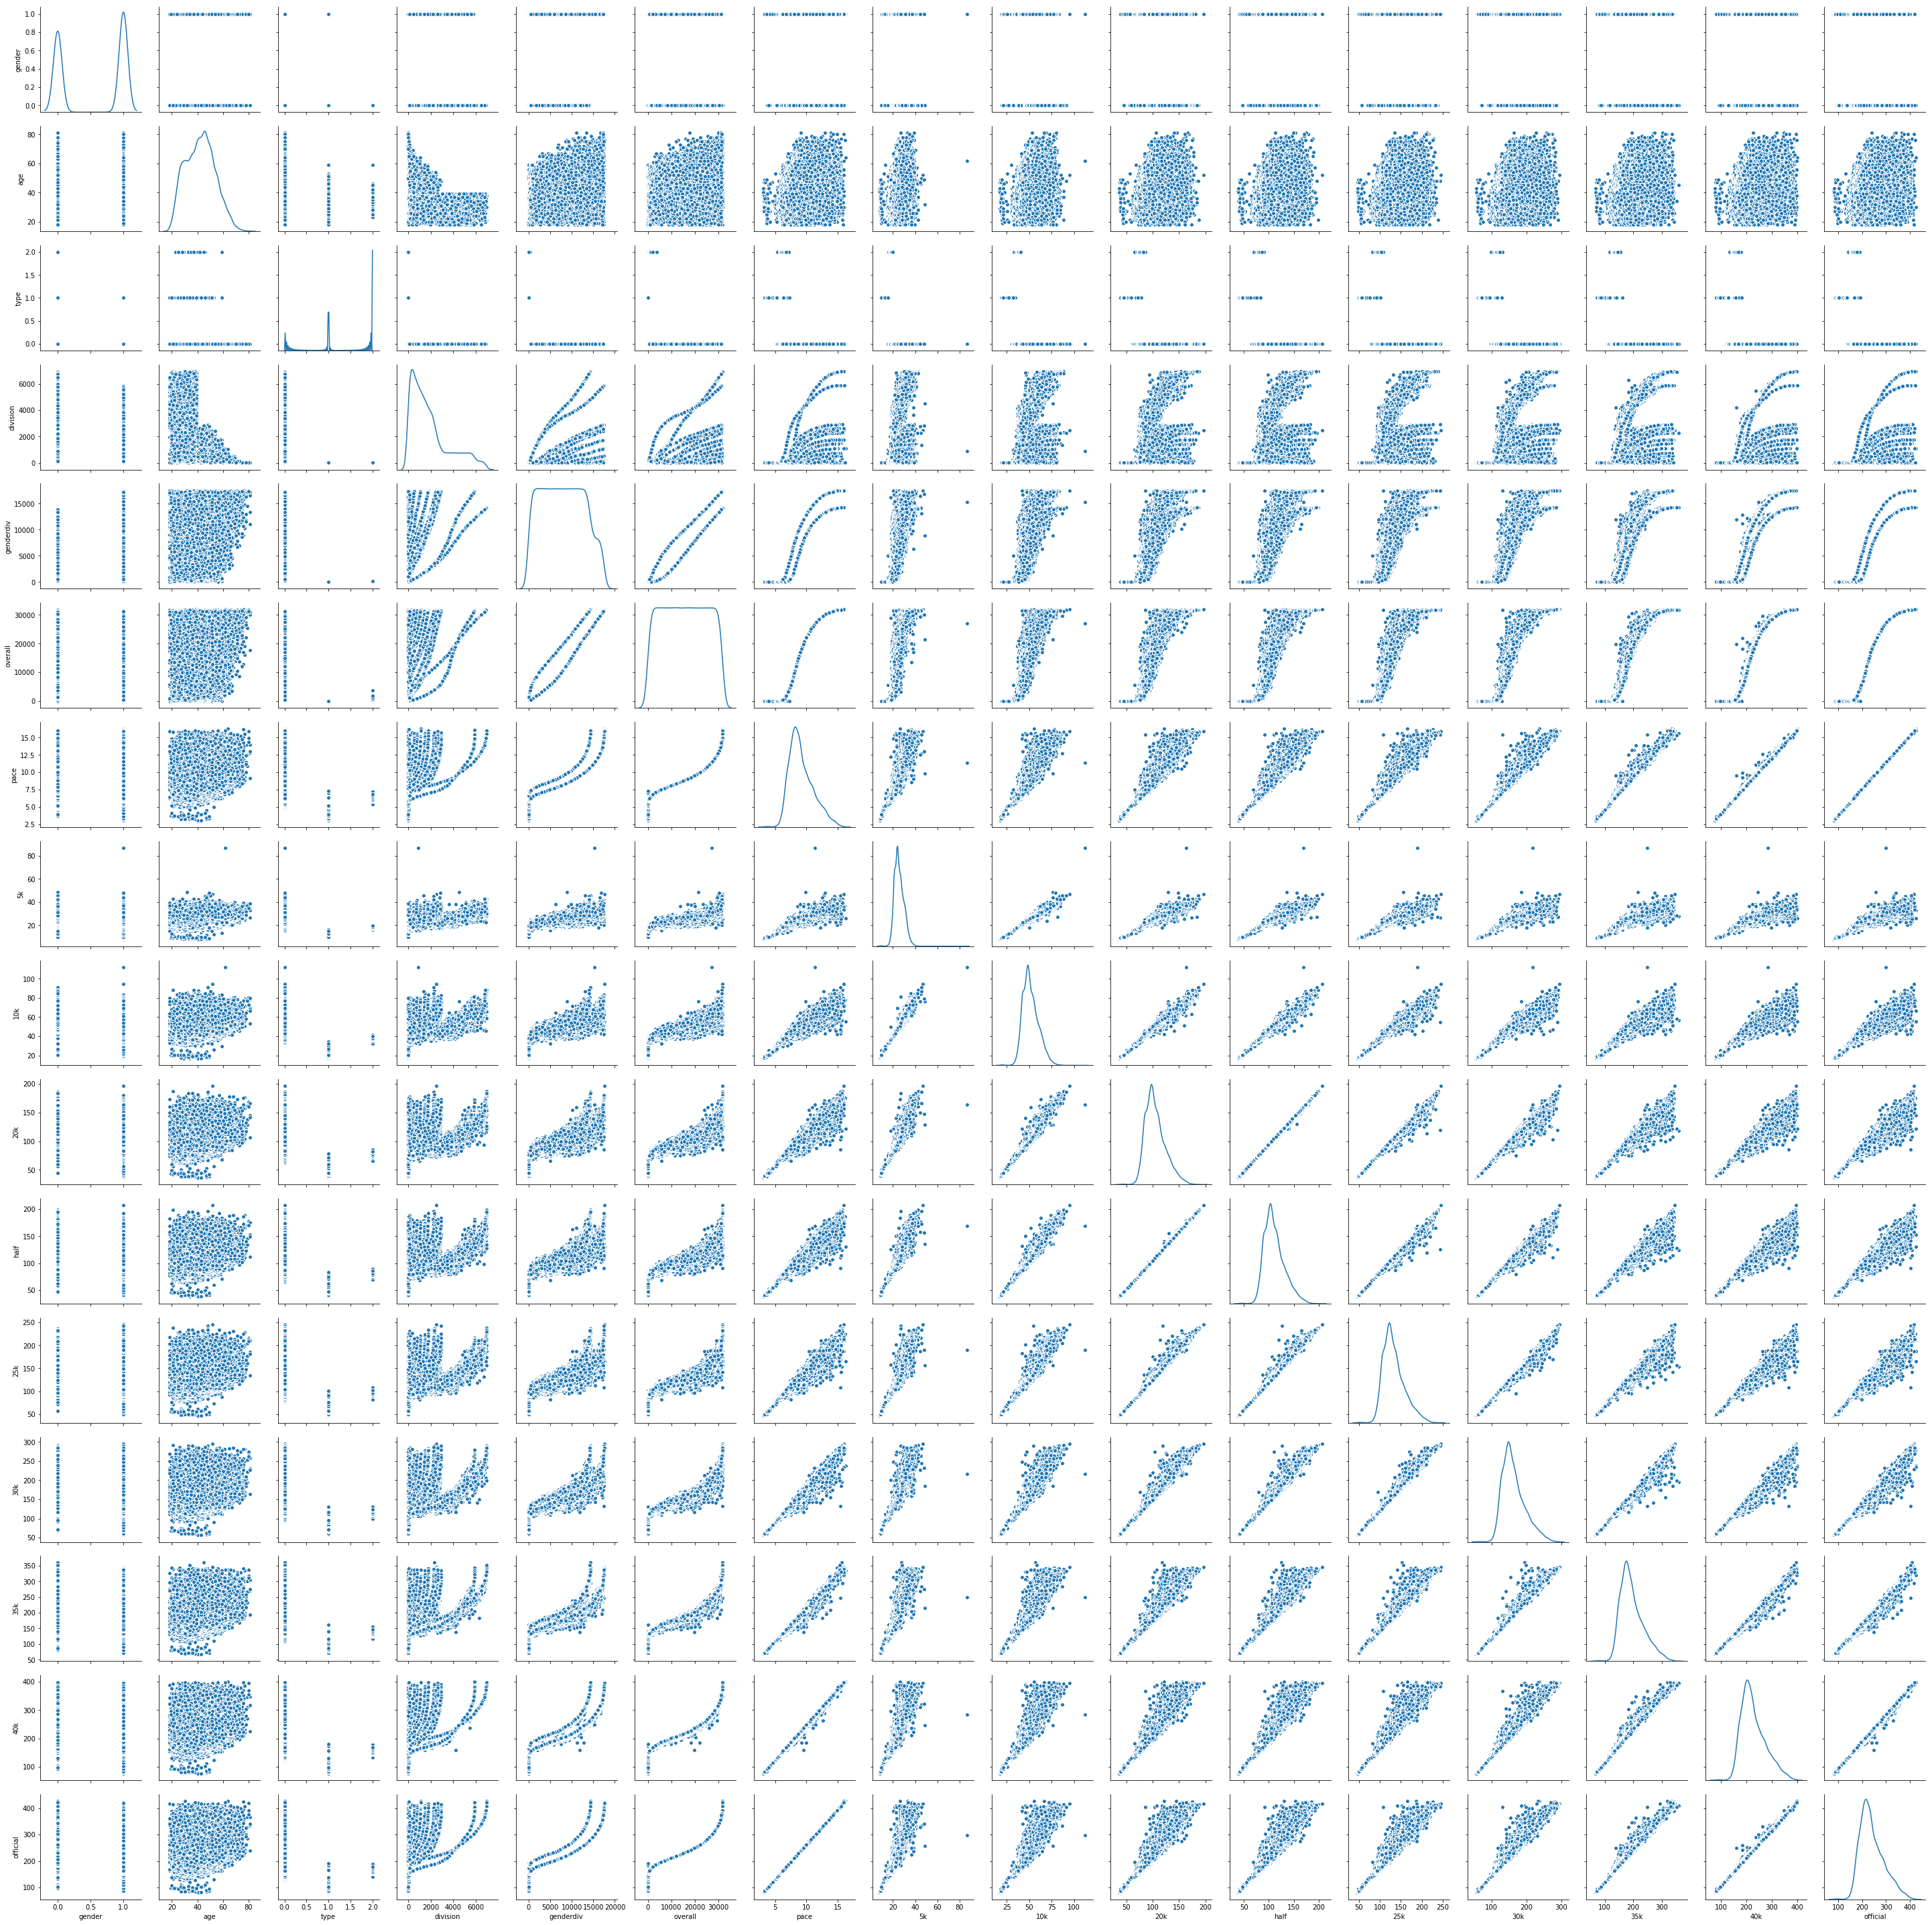

# 3. Clustering

In [5]:
X = pd.DataFrame(df['40k'])

In [17]:
# prepare X to cluster
X.head(5)

,40k
0,80.43
1,132.10
2,76.10
3,132.95
4,76.72


## 3.1. Kmeans

### 3.1.1. Silhouette score

In [7]:
from sklearn.cluster import KMeans
kmean = KMeans(n_clusters=8, #int
                tol=0.0001, #float
                n_init=10) #int
# y_pred = kmean.fit_predict(X)

In [58]:
from sklearn.model_selection import RandomizedSearchCV

# Create a parameter grid: map the parameter names to the
# values that should be searched:
param_grid = dict(
    n_clusters=[2],
    tol=np.linspace(0.0001,100,10),
    n_init=[10,100,250,1000],
    algorithm=['auto','full','elkan'],
)

from sklearn.metrics import silhouette_score
def silhouette(estimator, X):
    clusters = estimator.fit_predict(X)
    score = silhouette_score(X, clusters)
    return score

# Instantiate the grid:
grid = RandomizedSearchCV(kmean, param_grid, cv=5, error_score=0.0,
                          scoring=silhouette, n_jobs=1, n_iter=10)

# fit the grid with data
grid.fit(X)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)

# gre = Gridsearchcv REsult
gre = pd.DataFrame(grid.cv_results_)
(gre.loc[gre.mean_test_score!=0] # skip zero scored rows
     [['rank_test_score','mean_fit_time','mean_test_score'] # get these col
          +['param_{}'.format(i) for i in grid.best_params_.keys()]]
    .sort_values('rank_test_score')) # sort by rank

0.6135140168717962
{'tol': 77.77780000000001, 'n_init': 10, 'n_clusters': 2, 'algorithm': 'full'}


,rank_test_score,mean_fit_time,mean_test_score,param_tol,param_n_init,param_n_clusters,param_algorithm
1,1,0.194756,0.613514,77.7778,10,2,full
9,2,0.192061,0.610423,33.3334,10,2,full
7,3,0.063488,0.610309,44.4445,10,2,elkan
4,4,1.489322,0.606321,77.7778,250,2,elkan
6,5,66.373993,0.606030,0.0001,1000,2,full
5,6,0.593552,0.605789,44.4445,100,2,elkan
3,7,0.063388,0.605567,100,10,2,elkan
2,8,0.197351,0.603699,66.6667,10,2,full
8,9,0.186870,0.603294,100,10,2,full
0,10,0.087945,0.602644,88.8889,10,2,elkan


In [18]:
from sklearn.cluster import KMeans
kmean = KMeans(n_clusters=2,
                tol= 77.7777,
                n_init=10,
                algorithm='full',
                n_jobs=16)
y_pred = kmean.fit_predict(X)

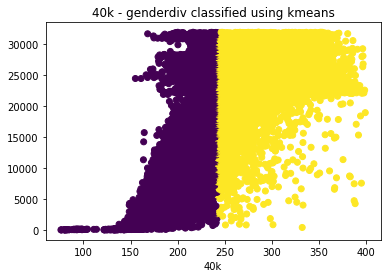

### 3.1.2. (test) calinski harabaz

In [8]:
from sklearn.model_selection import RandomizedSearchCV

# Create a parameter grid: map the parameter names to the
# values that should be searched:
param_grid = dict(
    n_clusters=[2],
    tol=np.linspace(0.0001,100,10),
    n_init=[10,100,250,1000],
    algorithm=['auto','full','elkan'],
)

from sklearn.metrics import calinski_harabaz_score
def calinski(estimator, X):
    clusters = estimator.fit_predict(X)
    score = calinski_harabaz_score(X, clusters)
    return score

# Instantiate the grid:
grid = RandomizedSearchCV(kmean, param_grid, cv=5, error_score=0.0,
                          scoring=calinski, n_jobs=1, n_iter=10)

# fit the grid with data
grid.fit(X)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)

# gre = Gridsearchcv REsult
gre = pd.DataFrame(grid.cv_results_)
(gre.loc[gre.mean_test_score!=0] # skip zero scored rows
     [['rank_test_score','mean_fit_time','mean_test_score'] # get these col
          +['param_{}'.format(i) for i in grid.best_params_.keys()]]
    .sort_values('rank_test_score')) # sort by rank

9872.364915594115
{'tol': 88.8889, 'n_init': 1000, 'n_clusters': 2, 'algorithm': 'auto'}


,rank_test_score,mean_fit_time,mean_test_score,param_tol,param_n_init,param_n_clusters,param_algorithm
4,1,5.615762,9872.364916,88.8889,1000,2,auto
6,2,5.603009,9872.362366,11.1112,1000,2,elkan
9,3,0.567897,9872.316738,44.4445,100,2,elkan
1,4,4.227543,9872.302742,22.2223,250,2,full
5,5,0.564703,9872.210126,66.6667,100,2,elkan
8,6,0.567199,9872.193516,66.6667,100,2,auto
0,7,0.164258,9872.162832,0.0001,10,2,elkan
7,8,1.697443,9871.846489,22.2223,100,2,full
2,9,1.689018,9870.859467,88.8889,100,2,full
3,10,0.059096,9841.774017,100,10,2,elkan


In [14]:
from sklearn.cluster import KMeans
kmean = KMeans(n_clusters=2,
                tol= 88.8889,
                n_init=1000,
                algorithm='auto',
                n_jobs=16)
y_pred = kmean.fit_predict(X)

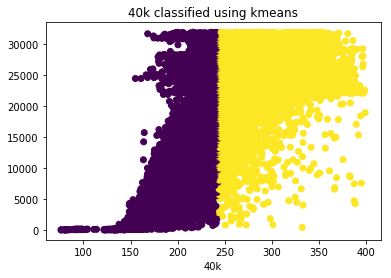

## 3.2. DBSCAN

In [38]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=10, #float
                min_samples=50, #int
                metric='euclidean', # 'cosine','manhattan',
                algorithm='auto') # 'ball_tree','kd_tree','brute'
y_pred = dbscan.fit_predict(X)

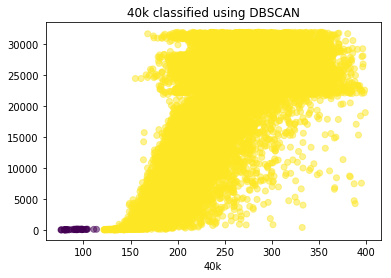

In [17]:
plt.scatter(X['40k'], X['40k'].index, c=y_pred, alpha=0.5)
plt.xlabel('40k')
plt.title("40k classified using DBSCAN")
plt.show()

### 3.2.1. Silhouette score

In [36]:
from sklearn.metrics import silhouette_score
silhouette_score(X, y_pred)

MemoryError: 

### 3.2.2. (test) Calinski - Harabaz score

In [10]:
from sklearn.metrics import calinski_harabaz_score
calinski_harabaz_score(X, y_pred)

367.220352567288

# 4. Discover the pattern of clustered item

We plot the pattern of 40k using some features:

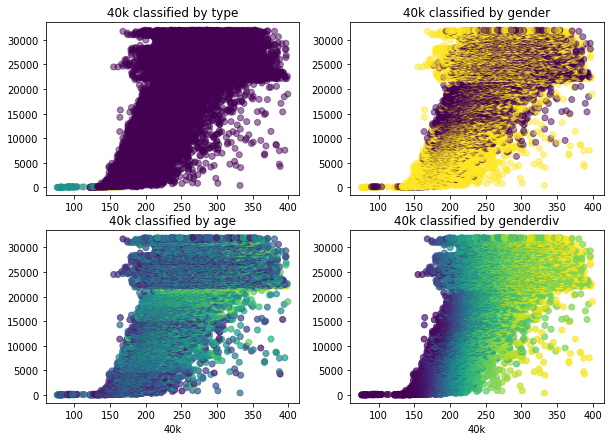

It appears that the figure of "40k classified by type" has the same pattern with "40k classified by DBSCAN". We plot another figure to check this pattern:

In [ ]:
# error

# 5. Conclusion
The DBSCAN model is better to cluster 40k in this database but the validation methods are not suitable in this case